# Prepare Dataset: Compute Stats and Normalize
> Dataset: `ile_de_france_dataset_linearinterp_avgmodels.csv`<br>

> Compute dataset statistics, normalize and clean raw datasets and save them as new `.npy` pickle files

Load a raw dataset, then
1. Compute dataset stats and write it to `./data_stats.csv`.
    - Read/import it as `pd.read_csv('./data_stats.csv',header=0,index_col=0)`
1. Normalize raw dataset with given mean/median and scale.
    - e.g. for lab2 in autocaffe we use data stat-s after interpolation.
1. Save normalized datasets as `./train_norm.npy` and `./test_norm.npy`
    - You can later load them with numpy, e.g.
    ```python
    with open('train_norm.npy', 'rb') as f:
        train_norm = np.load(f)
    ```
1. Obtain persistence loss (for normalized data with MSE loss, or any other loss that you set)
    - note that session 5 uses MSE loss and an additional factor of 0.5x for persistence loss ([_see video_](https://youtu.be/TSHc60ZI7cU?t=268))
    - save it to `./persistence_T{}.npy` where `{}` is replaced by the lead time, e.g. `./persistence_T5.npy`.
    - You can load it back with the code below:
```python
with open('persistence_T5.npy','rb') as f:
    x=np.load(f,allow_pickle=True).item()
```
`x` is a python `dict` object.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#For running in JupyterHub:
import os
if os.path.basename(os.getcwd())!='P003':
    print('Not in /P003 folder, changing directory to P003')
    lib_path = os.path.expanduser(os.path.relpath('~/images/codesDIR/datathon2020/P003'))
    os.chdir(lib_path)

In [3]:
# import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

In [4]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8,8)
matplotlib.rcParams['font.size']= 22 # use for presentation
pd.options.mode.chained_assignment = None

In [5]:
from src import datautils

## Load Raw Dataset

In [6]:
ls

0_normalize_linearinterp_avgmodels.ipynb
1_preprocess_linearinterp_avgmodels.ipynb
2_train_nn_linearinterp_avgmodels.ipynb
3_deploy_linearinterp_avgmodels-Copy1.ipynb
3_deploy_linearinterp_avgmodels.ipynb
Introduction.ipynb
README.md
__pycache__/
best_models/
datasets/
deploy_models.py
ile_de_france_dataset_linearinterp.csv
ile_de_france_dataset_linearinterp_avgmodels.csv
ile_de_france_dataset_nearestinterp.csv
ile_de_france_dataset_nearestinterp_avgmodels.csv
norm_linearinterp_avgmodels.csv
norm_linearinterp_avgmodels.npy
persistence_T18.npy
preprocessed_linearinterp_avgmodels/
raw_data_stats_linearinterp_avgmodels.csv
src@
trader.py


In [18]:
pd.concat([df,df.loc[pd.to_datetime(df.index)>pd.to_datetime('2020-12-01 00:00:00')]],axis=1,sort=True)

,Energy(kWh),guitrancourt_sin,guitrancourt_cos,lieusaint_sin,lieusaint_cos,lvs-pussay_sin,lvs-pussay_cos,parc-du-gatinais_sin,parc-du-gatinais_cos,arville_sin,...,parc-du-gatinais_sin,parc-du-gatinais_cos,arville_sin,arville_cos,boissy-la-riviere_sin,boissy-la-riviere_cos,angerville-1_sin,angerville-1_cos,angerville-2_sin,angerville-2_cos
2017-01-01 00:00:00,0.0,-1.499876,-1.947164,-1.416860,-1.590014,-1.613606,-1.540750,-1.372539,-1.426199,-1.385403,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,0.0,-1.352363,-2.070153,-1.320265,-1.728145,-1.542968,-1.648633,-1.321926,-1.523128,-1.331217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,0.0,-1.204850,-2.193142,-1.223669,-1.866275,-1.472331,-1.756515,-1.271314,-1.620056,-1.277031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 03:00:00,0.0,-1.057337,-2.316132,-1.127074,-2.004405,-1.401693,-1.864398,-1.220701,-1.716985,-1.222844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 04:00:00,0.0,-0.909825,-2.439121,-1.030479,-2.142535,-1.331055,-1.972280,-1.170088,-1.813913,-1.168658,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-16 01:00:00,5000.0,-2.660067,0.607900,-2.357192,1.391058,-1.708809,1.439911,-2.154578,1.115467,-2.156291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-16 02:00:00,5000.0,-2.627063,0.270881,-2.290227,1.170556,-1.718122,1.142669,-1.851086,0.970689,-1.875453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-16 03:00:00,5000.0,-2.594059,-0.066138,-2.223261,0.950054,-1.727434,0.845426,-1.547594,0.825911,-1.594614,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-16 04:00:00,5000.0,-2.712416,-0.060728,-2.385370,0.617604,-1.938793,0.646733,-1.692115,0.548886,-1.741222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# read the data
df = pd.read_csv('./ile_de_france_dataset_linearinterp_avgmodels.csv',header=0,index_col=0)

# shape and data types of the data
print(df.shape)
df.head(4)

(31014, 17)


,Energy(kWh),guitrancourt_sin,guitrancourt_cos,lieusaint_sin,lieusaint_cos,lvs-pussay_sin,lvs-pussay_cos,parc-du-gatinais_sin,parc-du-gatinais_cos,arville_sin,arville_cos,boissy-la-riviere_sin,boissy-la-riviere_cos,angerville-1_sin,angerville-1_cos,angerville-2_sin,angerville-2_cos
2017-01-01 00:00:00,0.0,-1.499876,-1.947164,-1.416860,-1.590014,-1.613606,-1.540750,-1.372539,-1.426199,-1.385403,-1.421186,-1.547957,-1.555232,-1.576832,-1.537235,-1.576832,-1.537235
2017-01-01 01:00:00,0.0,-1.352363,-2.070153,-1.320265,-1.728145,-1.542968,-1.648633,-1.321926,-1.523128,-1.331217,-1.522861,-1.476503,-1.668845,-1.509123,-1.639929,-1.509123,-1.639929
2017-01-01 02:00:00,0.0,-1.204850,-2.193142,-1.223669,-1.866275,-1.472331,-1.756515,-1.271314,-1.620056,-1.277031,-1.624536,-1.405049,-1.782458,-1.441414,-1.742623,-1.441414,-1.742623
2017-01-01 03:00:00,0.0,-1.057337,-2.316132,-1.127074,-2.004405,-1.401693,-1.864398,-1.220701,-1.716985,-1.222844,-1.726211,-1.333595,-1.896071,-1.373704,-1.845318,-1.373704,-1.845318


In [8]:
df.iloc[31014*95//100]

Energy(kWh)              26000.000000
guitrancourt_sin             2.154745
guitrancourt_cos             2.389094
lieusaint_sin                2.045849
lieusaint_cos                2.316203
lvs-pussay_sin               2.930024
lvs-pussay_cos               1.869479
parc-du-gatinais_sin         2.643014
parc-du-gatinais_cos         2.657114
arville_sin                  2.610651
arville_cos                  2.634988
boissy-la-riviere_sin        2.736172
boissy-la-riviere_cos        2.019998
angerville-1_sin             2.902449
angerville-1_cos             1.926158
angerville-2_sin             2.900842
angerville-2_cos             1.924243
Name: 2020-05-12 15:00:00, dtype: float64

In [9]:
31014-1551

29463

## Compute Raw Data Stats
> Compute stat-s and later write them to `./raw_data_stats.csv`

In [ ]:
print(df['Energy(kWh)'].mean(), df['Energy(kWh)'].std())

17564.64419294512 19149.516942117796


In [11]:
x= (df['Energy(kWh)'].values-18000)/40000

In [23]:
x.std()

0.47873020539690797

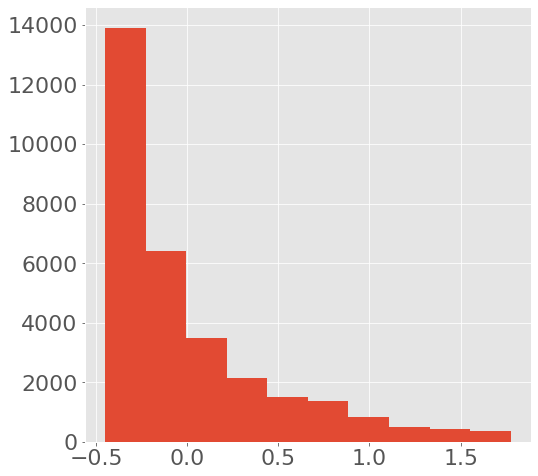

In [21]:
plt.hist(x);

Energy mean:$\mu\approx18000$ and s.d.:$2\times\sigma\approx40000$

In [ ]:
raw_data_stats_df = pd.DataFrame({'min':df.apply(np.min), 'max':df.apply(np.max),
                               'mean':df.apply(np.mean), 'median':df.apply(np.median),
                               'std':df.apply(np.std), 'range':df.apply(lambda x: np.max(x)-np.min(x)) })

# write to file
raw_data_stats_df.to_csv('./raw_data_stats_linearinterp_avgmodels.csv',
                     header=True,index=True)

print('Raw dataset statistics:')
raw_data_stats_df

Raw dataset statistics:


,min,max,mean,median,std,range
Energy(kWh),0.000000,89000.000000,17564.644193,10500.000000,19149.208216,89000.000000
guitrancourt_sin,-13.361518,7.469041,-0.969543,-0.871998,2.842252,20.830559
guitrancourt_cos,-12.211272,9.346530,-0.339961,-0.065764,2.905231,21.557802
lieusaint_sin,-11.403257,7.306754,-0.797735,-0.573077,2.660623,18.710011
lieusaint_cos,-11.047988,9.259653,-0.374114,-0.222707,2.807013,20.307641
lvs-pussay_sin,-12.231048,7.284671,-0.929339,-0.788886,2.843486,19.515719
lvs-pussay_cos,-11.398956,8.723637,-0.338420,-0.151321,2.883375,20.122593
parc-du-gatinais_sin,-11.838507,7.867640,-0.813787,-0.631857,2.763721,19.706147
parc-du-gatinais_cos,-11.503961,8.907628,-0.424447,-0.273375,2.816599,20.411589
arville_sin,-11.813518,7.833618,-0.813964,-0.621000,2.756527,19.647136


In [ ]:
print('Maximum Speed Magnitudes:')
for farm in datautils.locations:
    print(f"max ({farm}): "+
          f"{np.max( np.sqrt(df[f'{farm}_cos']**2+df[f'{farm}_cos']**2) )}")

Maximum Speed Magnitudes:
max (guitrancourt): 17.269346940531026
max (lieusaint): 15.624214097600673
max (lvs-pussay): 16.120558256760013
max (parc-du-gatinais): 16.269057968836822
max (arville): 16.25093305935033
max (boissy-la-riviere): 16.131217736310994
max (angerville-1): 16.140347742769645
max (angerville-2): 16.140347742769645


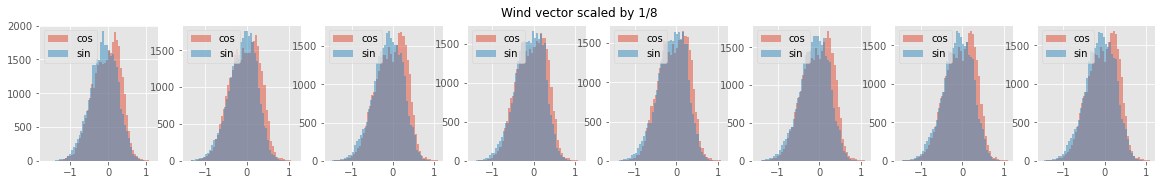

In [ ]:
_,axs  = plt.subplots(nrows=1,ncols=len(datautils.locations),figsize=[20,2.5])
wind_scale = 8
for k,ax in enumerate(axs.ravel()):
    ax.hist(df[f'{datautils.locations[k]}_cos']/wind_scale,bins=50,alpha=.5,label='cos');
    ax.hist(df[f'{datautils.locations[k]}_sin']/wind_scale,bins=50,alpha=.5,label='sin');
    ax.legend()
plt.suptitle(f"Wind vector scaled by 1/{wind_scale}");

Wind \[sin,cos\] mean: $\mu\approx0$ and scale: $\frac{speed}{2}\approx8$

## Normalise Dataset and Save to File
1. Normalise energy using mean:$\mu\approx18000$ and s.d.:$2\times\sigma\approx40000$
$$x_{normalised} = \frac{x_{raw}-\mu}{2\times\sigma}=\frac{x_{raw} - 18000}{40000}$$
1. Compute Persistence `T+lag_time` for the normalised data
1. Normalise wind vectors (\[cos,sin\] vectors) using mean:$\mu\approx0$ and scale: $s=\frac{speed}{2}\approx8$
$$x_{normalised} = \frac{x_{raw}}{8}$$
1. Later, split normalized dataset into training and testing datasets, and then save them to use it later:
    - E.g. 70/30 split: where we use the 1st 70% as training data, and the remaining examples as test data. (w/o losing any examples)
    - Save normalized trainig and test datasets into `./train_norm.npy` and `./test_norm.npy`

### Normalize the Raw or  Interpolated Data

In [ ]:
data_norm = np.zeros(df.shape)

# Energy:
# Shift data with mean or median
shift_ = 18000.0 # e.g. mean , lookup from stats, you can round it up
scale_ = 40000.0 # e.g. 2xS.D., lookup from stats
data_norm[:,0] = (df['Energy(kWh)'].values - shift_)/scale_

# Wind vector
wind_scale_ = 8.0 # half of max speed
data_norm[:,1:] = df[df.columns[1:]].values/wind_scale_

- write normalized dataset (full, we have not yet split it)

In [ ]:
# normalized training dataset:
with open('norm_linearinterp_avgmodels.npy', 'wb') as f:
    np.save(f, data_norm)
# to CSV
data_norm_df = pd.DataFrame(data=data_norm)
data_norm_df.to_csv('norm_linearinterp_avgmodels.csv',header=False,index=False)

In [8]:
# # For loading dataset back use:
# with open('norm_linearinterp_avgmodels.npy', 'rb') as f:
#     data_norm = np.load(f)

Norm-d data:
mean: [-0.0108839  -0.12119285 -0.04249512 -0.09971693 -0.04676421 -0.11616743
 -0.0423025  -0.10172339 -0.05305584 -0.10174556 -0.05252665 -0.11243639
 -0.04534634 -0.11442022 -0.04247591 -0.11442634 -0.04255367]
std: [0.47873021 0.35528144 0.36315383 0.33257789 0.35087663 0.3554358
 0.36042192 0.34546516 0.35207488 0.34456582 0.35186215 0.34882799
 0.35732809 0.35408748 0.35806161 0.35398944 0.35810568]
median:[-0.1875     -0.10899975 -0.00822052 -0.07163465 -0.02783832 -0.0986107
 -0.01891507 -0.07898213 -0.03417191 -0.07762502 -0.03353878 -0.0917143
 -0.02394762 -0.09724755 -0.01977148 -0.09728729 -0.01984066]


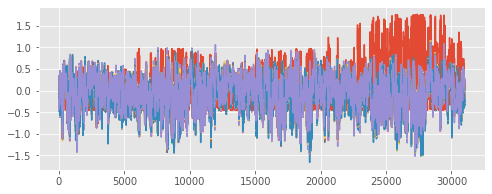

In [9]:
print(f'Norm-d data:\nmean: {data_norm.mean(axis=0)}\n'+
     f'std: {data_norm.std(axis=0)}\nmedian:{np.median(data_norm,axis=0)}')
plt.figure(figsize=[8,3])
plt.plot(data_norm);

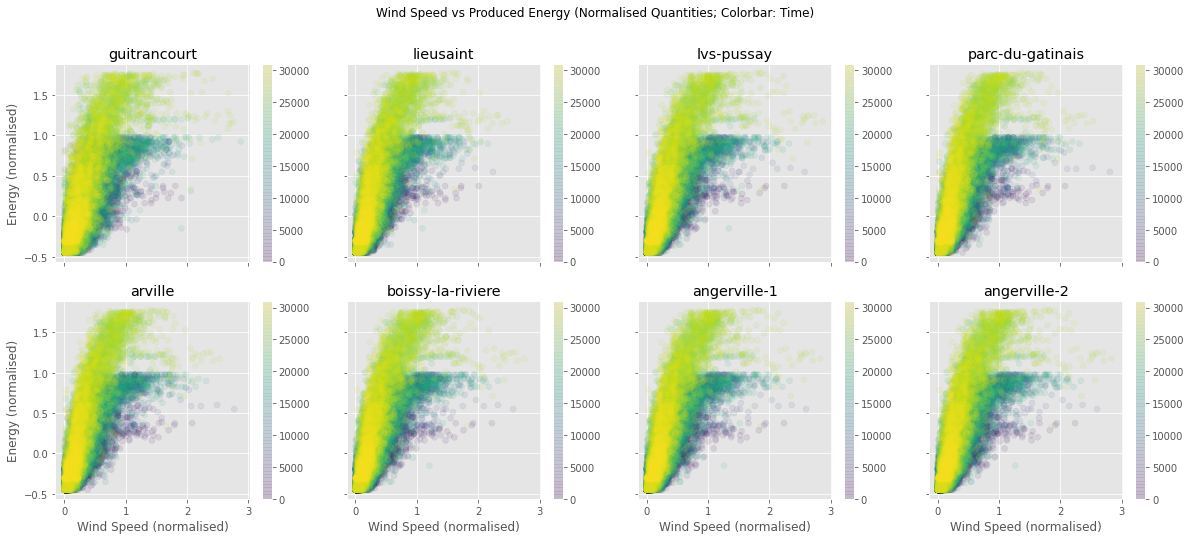

In [13]:
fig,axs= plt.subplots(nrows=2,ncols=4,figsize=[20,8],sharex=True,sharey=True)

for l,(k,ax) in enumerate(zip(range(1,data_norm.shape[1],2),axs.ravel())):
    scplt=ax.scatter(data_norm[:,k]**2+data_norm[:,k+1]**2,data_norm[:,0],c=np.arange(data_norm.shape[0]),alpha=.1)
    fig.colorbar(scplt,ax=ax)
    ax.set_title(f"{datautils.locations[l]}")
    if l%4==0:
        ax.set_ylabel('Energy (normalised)')
    if l>3:
        ax.set_xlabel('Wind Speed (normalised)')

plt.suptitle('Wind Speed vs Produced Energy (Normalised Quantities; Colorbar: Time)');
plt.show()

## Persistence Loss (for Normalized Data with MSE loss)

- Autocaffe videos use "Euclidean Loss" from Caffe 1.0, which is `0.5*MSE`
- note that session 5 uses MSE loss and an additional factor of 0.5x for persistence loss ([_see video_](https://youtu.be/TSHc60ZI7cU?t=268))
---
Compute persistence loss and save it to `./persistence_T{}.npy` where `{}` is replaced by the lead time, e.g. `./persistence_T5.npy`.
- You can load it back with the code below:
```python
with open('persistence_T5.npy','rb') as f:
    x=np.load(f,allow_pickle=True).item()
```
`x` is a python `dict` object.
- Here, `persistence` is computed starting from the first elements of `train_norm` (or `test_norm`). Your exact training/testing dataset will start from the last element in the window, which will be set as first $Y(T+0)$.

In [ ]:
from src.utils import persistence_loss

In [ ]:
# # For loading dataset back use:
# with open('norm_linearinterp_avgmodels.npy', 'rb') as f:
#     data_norm = np.load(f)

In [ ]:
Tlead = 18
# utils.persistence_loss by default uses MSE as metric
persistence_data = np.array({'lead_time':Tlead,
                             'Persistence_Euclidean':
                             persistence_loss(data_norm[:,0],lead_time=Tlead,metric='euclidean'),
                             'Persistence_MSE':
                             persistence_loss(data_norm[:,0],lead_time=Tlead,metric='mse'),
                            'Persistence_MAE':
                            persistence_loss(data_norm[:,0],lead_time=Tlead, metric= 'mae')})

with open(f'persistence_T{Tlead}.npy', 'wb') as f:
    np.save(f,persistence_data)

# persistence_data = persistence_data.item()
print(f'Persistence T+{Tlead}\n---\n')
for k in persistence_data.item():
    print(k,':',persistence_data.item()[k])

Persistence T+18
---

lead_time : 18
Persistence_Euclidean : 0.10196654967828511
Persistence_MSE : 0.20393309935657022
Persistence_MAE : 0.3105751548586914


In [ ]:
data_norm.shape[0] - data_norm.shape[0]*95//100

1551

---
**WE WILL SPLIT TRAIN/TEST AFTER PRE-PROCESSING**

---

### Plot Test/Train

In [ ]:
# split_index = data_norm.shape[0]*70//100
# train_norm = data_norm[:split_index]
# test_norm = data_norm[split_index:]
# print(f'data_norm.shape[0]== train_norm.shape[0]+test_norm.shape[0]: {data_norm.shape[0]== train_norm.shape[0]+test_norm.shape[0]}')

In [ ]:
# # For presentation:
# # with plt.rc_context({'font.size': 22}):
# #     _,axs = plt.subplots(ncols=2,nrows=1,figsize=[20,5])
# #     axs[0].plot(train_norm,label='Train',alpha=.5)
# #     axs[1].plot(test_norm,color='b',label='Test',alpha=.5)
# #     for k in range(axs.shape[0]):
# #         axs[k].legend()
# #     plt.suptitle('Normalized Data');
# _,axs = plt.subplots(ncols=2,nrows=1,figsize=[10,3])
# axs[0].plot(train_norm,label='Train',alpha=.5)
# axs[1].plot(test_norm,color='b',label='Test',alpha=.5)
# for k in range(axs.shape[0]):
#     axs[k].legend()
# plt.suptitle('Normalized Data');

### Histograms:

In [ ]:
# # Number of bins:
# N_bins = 50
# # histogram range:
# x_range = [min([train_norm.min(),test_norm.min()]),
#            max([train_norm.max(),test_norm.max()])]
# hist_bins = np.linspace(x_range[0],x_range[1],N_bins)

In [ ]:
# # # For presentation:
# # with plt.rc_context({'font.size': 22}):
# #     _, axs = plt.subplots(nrows=1,ncols=2,figsize=[15,5],sharex=True,squeeze=True)
# #     # Train
# #     axs[0].hist(train_norm, bins=hist_bins)
# #     axs[0].set_title('Train')
# #     # Test
# #     axs[1].hist(test_norm, bins=hist_bins)
# #     axs[1].set_title('Test')
# #     plt.show()
# _, axs = plt.subplots(nrows=1,ncols=2,figsize=[5,2],sharex=True,squeeze=True)
# # Train
# axs[0].hist(train_norm, bins=hist_bins)
# axs[0].set_title('Train')
# # Test
# axs[1].hist(train_norm, bins=hist_bins)
# axs[1].set_title('Test')
# plt.show()

---
Difference $Y(T+1)-Y(T+0)$ for normalized data:

In [ ]:
# _,axs = plt.subplots(ncols=3,nrows=1,figsize=[16,2.5],squeeze=True)
# # Plot time series
# axs[0].plot(train_norm)
# axs[0].set_title('Train (norm)')
# axs[1].plot(test_norm)
# axs[1].set_title('Test (norm)')
# # deltaY: differences Y(t+1)-Y(t)
# axs[2].hist((train_norm[1:]-train_norm[:-1]),bins=25,density=True,alpha=.5,label='train')
# axs[2].hist(test_norm[1:]-test_norm[:-1],bins=25,density=True,alpha=.5,label='test')
# plt.title('Differences, $Y(T+1)-Y(T+0)$')
# plt.legend()
# plt.show()

---

- What do we know about the dataset, e.g. how is it generated? any regularities?
- Note the sharp peak near zero for Y difference data

---

## Write Normalized Train/Test Datasets to New Files

- Write arrays to `./train_norm.npy` and `./test_norm.npy`

In [ ]:
# # normalized training dataset:
# with open('train_norm.npy', 'wb') as f:
#     np.save(f, train_norm)

# # normalized test dataset:
# with open('test_norm.npy', 'wb') as f:
#     np.save(f, test_norm)
    
# # # For loading them back use:
# # # with open('train_norm.npy', 'rb') as f:
# # #    x_test = np.load(f)